### Multiclass task: non-event vs. SI vs. SSC 
Notebook structure:
1. Balance classes: undersample non-events, retaining only as many samples as the majority class between SI and SSC (namely SSC); oversample the minority class by applying SMOTE on the training set.
2. Pre-process the data via wavelet scattering network.
3. Train multi-class classifiers, perform 10 folds cross-validation, and evaluate performances.
5. Repeat the process with a reduced set of features (criteria adopted: random forest Gini's importance).

In [1]:
import pandas as pd
import os
import random 
import numpy as np
from collections import Counter
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from classification_utils import fill_NaN, compute_Scattering1D, get_logistic_model, train_logistic_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE, SVMSMOTE
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold, StratifiedKFold, GridSearchCV
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

random.seed(2)
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(2)

#### Paths

In [2]:
ssc_path = 'labelled_data/SSC/'
si_path = 'labelled_data/SI/'
non_event_path = 'labelled_data/before_event/'
multiclass_sample = 'labelled_data/sample_for_multiclass_w_SMOTE.txt'

In [3]:
# scattering params
T = 20*60 + 1 
J = 10
Q = 5 
log_eps = 1e-6

### Classification using Wavelets Scattering Network features & SMOTE to balance classes

#### Get data

use always same sample for reproducibility

In [4]:
if os.path.exists(multiclass_sample):
    # if I already extracted a sample, read it
    all_seq_data_files = []
    with open(multiclass_sample, 'r') as file:
        for line in file:
            all_seq_data_files.append(line.strip())
    print( Counter([all_seq_data_files[i].split('/')[1] for i in range(len(all_seq_data_files))]) )

    si_files, ssc_files, random_non_ev_files = [], [], []
    for path in all_seq_data_files:
        if path.split('/')[1] == 'SI':
            si_files.append(path)
        elif path.split('/')[1] == 'SSC':
            ssc_files.append(path)
        elif path.split('/')[1] == 'before_event':
            random_non_ev_files.append(path)
        else:
            raise ValueError('File not belonging to any class!')
else:

    # get all data files paths
    # use all SI and all SSC, and a sample of non-events 
    si_files = [si_path + item for item in os.listdir(si_path)] 
    ssc_files = [ssc_path + item for item in os.listdir(ssc_path)] 
    non_ev_files = [non_event_path + item for item in os.listdir(non_event_path)]

    print('SI: {}, SSC: {}'.format(len(si_files), len(ssc_files)))

    # number of non-event to random sample (take as many non-events as the majority class between SSC & SI)
    sample_non_ev = np.max([len(si_files), len(ssc_files)])
    print('Non-events: {}'.format(sample_non_ev))

    # SAMPLE NON-EVENT
    random_non_ev_files = random.sample(non_ev_files, sample_non_ev)
    all_seq_data_files = si_files + ssc_files + random_non_ev_files

    # save sampled used to use always the same in the following trials
    with open(multiclass_sample, 'w') as file:
        for string in all_seq_data_files:
            file.write(string + '\n')

Counter({'SSC': 120, 'before_event': 120, 'SI': 73})


In [5]:
# initialize 2D tensors (each row is a different sequence)

seq_si = torch.zeros(len(si_files), T, dtype=torch.float32)
seq_ssc = torch.zeros(len(ssc_files), T, dtype=torch.float32)
seq_ne = torch.zeros(len(random_non_ev_files), T, dtype=torch.float32)

lab_dict = {'SSC':seq_ssc, 'SI':seq_si, 'before_event':seq_ne} # which tensor to update based on class

filling_method = 'linear_interpolation' 

indx_to_update = {'SSC':0, 'SI':0, 'before_event':0} # index of seq to update in each tensor 
for e in all_seq_data_files:
    # get sequence
    df = pd.read_csv(e)
    seq = df.sort_values(by=['Date_UTC' if 'Date_UTC' in df.columns else 'Unnamed: 0']).dbn_nez

    # get right tensor to fill
    sequences_class_x = lab_dict[e.split('/')[1]]
    
    # deal with NaN
    seq_filled = fill_NaN(seq, filling_method)

    # convert from np array to pytorch tensor
    seq_filled = torch.from_numpy(seq_filled)

    # compute columns from which to start filling
    starting_col_index = (T - seq_filled.numel()) // 2

    # add data to sequences tensor
    i = indx_to_update[e.split('/')[1]]
    sequences_class_x[i,starting_col_index:starting_col_index + seq_filled.numel()] = seq_filled

    # update counter (next row)
    indx_to_update[e.split('/')[1]] += 1

In [6]:
len(seq_ne), len(seq_si), len(seq_ssc)

(120, 73, 120)

In [7]:
# concat tensors and labels
all_seqs = torch.cat([seq_si, seq_ssc, seq_ne], dim=0).numpy()  
ys = len(seq_si)*['SI'] + len(seq_ssc)*['SSC'] + len(seq_ne)*['non-event']

# to tensor
seqs = torch.from_numpy(all_seqs)

# labels to tensor + map classes to int
# replace str with int code
lab_to_int = {'non-event': 0, 'SI': 1, 'SSC': 2}
y = list(map(lambda x: lab_to_int[x], ys))
# to tensor
y = torch.tensor(y)

#### Split Train/Test sets

In [8]:
# split train and test set 
X_train, X_test, y_train, y_test = train_test_split(seqs, y, test_size=0.3, shuffle=True, random_state=2) 

In [9]:
np.shape(seqs), np.shape(X_train), np.shape(X_test)

(torch.Size([313, 1201]), torch.Size([219, 1201]), torch.Size([94, 1201]))

#### Create synthetic sequences using SMOTE
Picked as many non-event as the majority class between SSC and SI (aka SSC);
now use SMOTE (oversampling) to balance the classes.

**NOTE**: apply SMOTE only on train set (test set should contain only real sequences).

In [10]:
# SMOTE
# smote = SMOTE(k_neighbors=20, random_state=2)
smote = SVMSMOTE(k_neighbors=5, random_state=2)
X_train_resampled_np, y_train_resampled_np = smote.fit_resample(X_train, y_train)

# to tensor
X_train_resampled, y_train_resampled = torch.tensor(X_train_resampled_np), torch.tensor(y_train_resampled_np)

In [11]:
# shuffle so that synthetic sequences are not all the end
X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=2)

In [12]:
Counter(y_train_resampled_np)

Counter({0: 90, 2: 90, 1: 70})

#### Wavelet Scattering Transform to extract features

In [13]:
Sc_all_train = compute_Scattering1D(X_train_resampled, T, J, Q, log_eps)
Sc_all_test = compute_Scattering1D(X_test, T, J, Q, log_eps)

In [14]:
np.shape(Sc_all_train)

torch.Size([250, 235])

In [15]:
np.shape(Sc_all_test)

torch.Size([94, 235])

In [16]:
np.isnan(Sc_all_train).any(), np.isnan(Sc_all_test).any()

(tensor(0, dtype=torch.uint8), tensor(0, dtype=torch.uint8))

#### Standardize data using training mean and variance

In [17]:
mu_train = Sc_all_train.mean(dim=0)
std_train = Sc_all_train.std(dim=0)

Sx_train = (Sc_all_train - mu_train) / std_train
Sx_test = (Sc_all_test - mu_train) / std_train

_________

#### Visualization

In [18]:
feats_df = pd.DataFrame({'feature_1':Sx_train[:,0], 'feature_2':Sx_train[:,1], 'feature_3':Sx_train[:,2], 
                         'feature_3rdlast':Sx_train[:,-3], 'feature_2ndlast':Sx_train[:,-2], 'feature_last':Sx_train[:,-1], 
                         'label':y_train_resampled})

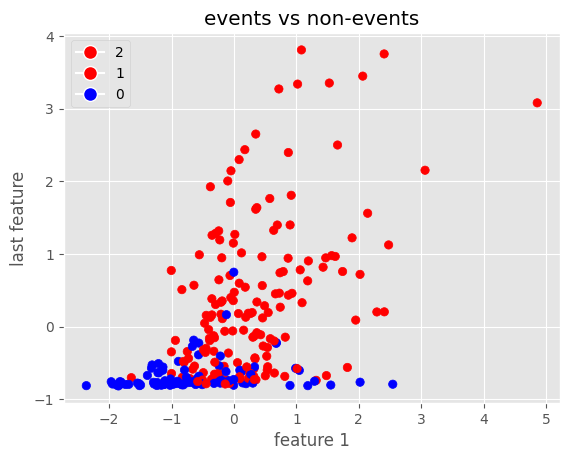

In [19]:
plt.scatter(feats_df['feature_1'], feats_df['feature_last'], c=feats_df['label'].map({2: 'red', 1: 'red', 0: 'blue'}))

plt.xlabel('feature 1')
plt.ylabel('last feature')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='2', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)])

plt.title('events vs non-events')
plt.show()

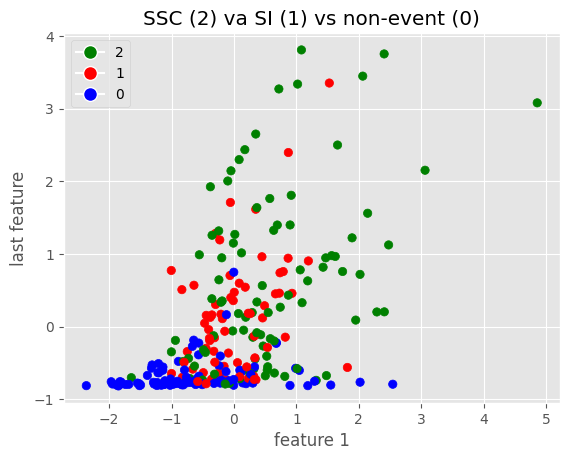

In [20]:
plt.scatter(feats_df['feature_1'], feats_df['feature_last'], c=feats_df['label'].map({2: 'green', 1: 'red', 0: 'blue'}))

plt.xlabel('feature 1')
plt.ylabel('last feature')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='2', markerfacecolor='green', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)])

plt.title('SSC (2) va SI (1) vs non-event (0)')
plt.show()

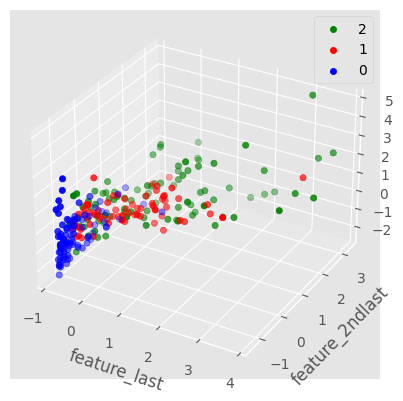

In [21]:
# columns
feat_discriminante = 'feature_last'
feat_y = 'feature_2ndlast' 
feat_z = 'feature_1'
label = 'label'


# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = {2: 'green', 1: 'red', 0: 'blue'}

for label_name, label_color in colors.items():
    subset = feats_df[feats_df[label] == label_name]
    ax.scatter(subset[feat_discriminante], subset[feat_y], subset[feat_z], c=label_color, label=label_name)

ax.set_xlabel(feat_discriminante)
ax.set_ylabel(feat_y)
ax.set_zlabel(feat_z)

ax.legend()

plt.show()


______

### Classification

#### Logistic Regression with 10-folds cross validation

In [22]:
def k_fold_cross_validation(X, y, num_folds, num_epochs, batch_size, random_seed=2):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)
    fold = 0
    results = {}

    for train_index, val_index in kf.split(X):
        # get fold
        fold += 1
        print(f'\nFold {fold}/{num_folds}:')

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]


        # define logistic regression model
        num_input = X_train.shape[-1]
        num_classes = y_train.unique().numel()
        model, optimizer, criterion = get_logistic_model(num_input, num_classes)

        # train model
        print('Training:')
        n_samples_train = X_train.shape[0]
        train_logistic_model(X_train, y_train, model, optimizer, criterion, num_epochs, n_samples_train, batch_size, verbose=True)


        # compute accuracy on validation set
        print('\nValidation:')
        resp_val = model.forward(X_val)
        avg_loss_val = criterion(resp_val, y_val)

        y_hat_val = resp_val.argmax(dim=1)
        accuracy_val = (y_val == y_hat_val).float().mean()

        print('Validation, average loss = {:1.3f}, accuracy = {:1.3f}'.format(avg_loss_val, accuracy_val))

        # other metrics
        precision = precision_score(y_val, y_hat_val, average='weighted')
        recall = recall_score(y_val, y_hat_val, average='weighted')
        f1 = f1_score(y_val, y_hat_val, average='weighted')

        results[fold] = {'model':model, 'validation_accuracy':accuracy_val.item(),
                         'precision':precision, 'recall':recall, 'F1':f1}

    return results


# 10-folds CV
num_folds = 10
num_epochs = 10
batch_size = 32
results = k_fold_cross_validation(Sx_train, y_train_resampled, num_folds, num_epochs, batch_size)


Fold 1/10:
Training:
Epoch 0, average loss = 0.694, accuracy = 0.653
Epoch 1, average loss = 0.690, accuracy = 0.658
Epoch 2, average loss = 0.669, accuracy = 0.684
Epoch 3, average loss = 0.647, accuracy = 0.698
Epoch 4, average loss = 0.634, accuracy = 0.711
Epoch 5, average loss = 0.626, accuracy = 0.716
Epoch 6, average loss = 0.616, accuracy = 0.707
Epoch 7, average loss = 0.608, accuracy = 0.711
Epoch 8, average loss = 0.601, accuracy = 0.720
Epoch 9, average loss = 0.594, accuracy = 0.733

Validation:
Validation, average loss = 0.655, accuracy = 0.640

Fold 2/10:
Training:
Epoch 0, average loss = 0.751, accuracy = 0.644
Epoch 1, average loss = 0.715, accuracy = 0.653
Epoch 2, average loss = 0.702, accuracy = 0.658
Epoch 3, average loss = 0.682, accuracy = 0.662
Epoch 4, average loss = 0.659, accuracy = 0.684
Epoch 5, average loss = 0.644, accuracy = 0.689
Epoch 6, average loss = 0.633, accuracy = 0.702
Epoch 7, average loss = 0.625, accuracy = 0.702
Epoch 8, average loss = 0.61

In [23]:
results

{1: {'model': Sequential(
    (0): Linear(in_features=235, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  ),
  'validation_accuracy': 0.6399999856948853,
  'precision': 0.6212987012987012,
  'recall': 0.64,
  'F1': 0.6201403508771929},
 2: {'model': Sequential(
    (0): Linear(in_features=235, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  ),
  'validation_accuracy': 0.7200000286102295,
  'precision': 0.8014285714285714,
  'recall': 0.72,
  'F1': 0.6857391304347825},
 3: {'model': Sequential(
    (0): Linear(in_features=235, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  ),
  'validation_accuracy': 0.7200000286102295,
  'precision': 0.762909090909091,
  'recall': 0.72,
  'F1': 0.71310407239819},
 4: {'model': Sequential(
    (0): Linear(in_features=235, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  ),
  'validation_accuracy': 0.7200000286102295,
  'precision': 0.6066666666666667,
  'recall': 0.72,
  'F1': 0.6579999999999999},
 5: {'model': Sequentia

In [24]:
acc, precision, recall, f1 = 0, 0, 0, 0

for k in results.keys():
    acc += results[k]['validation_accuracy']
    precision += results[k]['precision']
    recall += results[k]['recall']
    f1 += results[k]['F1']

print('Average accuracy (10-folds Cross-Validation): {}'.format(acc/num_folds))
print('Average precision (10-folds Cross-Validation): {}'.format(precision/num_folds))
print('Average recall (10-folds Cross-Validation): {}'.format(recall/num_folds))
print('Average F1 (10-folds Cross-Validation): {}'.format(f1/num_folds))

Average accuracy (10-folds Cross-Validation): 0.6760000139474869
Average precision (10-folds Cross-Validation): 0.6848110112110112
Average recall (10-folds Cross-Validation): 0.6759999999999999
Average F1 (10-folds Cross-Validation): 0.6576231494315637


In [25]:
max_recall = 0
for k in results.keys():
    if results[k]['recall'] > max_recall:
        max_recall = results[k]['recall']
        new_best_model = k

# model with highest recall
print('model with highest recall: fold {}, recall {}'.format(new_best_model, 
                                                             results[new_best_model]['recall'] ))

model with highest recall: fold 2, recall 0.72


In [26]:
best_model = results[new_best_model]['model']
criterion = torch.nn.NLLLoss() # negative log likelihood loss

# TEST SET
# accuracy
resp = best_model.forward(Sx_test)
avg_loss = criterion(resp, y_test)

y_hat = resp.argmax(dim=1)
acc = (y_test == y_hat).float().mean()

print('Model accuracy: ', acc.item())

# confusion matrix
preds_test = y_hat.numpy()
true_test = y_test.numpy()
confusion = confusion_matrix(true_test, preds_test)

# probabilities of class assignment
best_model.eval() 
with torch.no_grad():
    logits = best_model(Sx_test)
    probs = torch.softmax(logits, dim=1)

Model accuracy:  0.7340425252914429


In [27]:
probs

tensor([[9.5822e-03, 1.7812e-01, 8.1229e-01],
        [5.7731e-03, 1.8426e-01, 8.0997e-01],
        [3.4940e-02, 2.7571e-01, 6.8936e-01],
        [1.2343e-02, 1.7092e-01, 8.1674e-01],
        [1.9328e-01, 4.9321e-01, 3.1351e-01],
        [9.7298e-01, 1.4666e-02, 1.2358e-02],
        [1.8127e-01, 3.2849e-01, 4.9024e-01],
        [9.6506e-03, 1.8905e-01, 8.0130e-01],
        [9.7872e-01, 1.7876e-02, 3.4056e-03],
        [9.8642e-03, 1.3943e-01, 8.5070e-01],
        [2.5237e-01, 2.3938e-01, 5.0825e-01],
        [3.7948e-03, 3.8330e-01, 6.1291e-01],
        [1.0507e-03, 9.8344e-02, 9.0061e-01],
        [5.0177e-02, 2.6866e-01, 6.8116e-01],
        [8.1583e-01, 1.4742e-01, 3.6750e-02],
        [2.6416e-01, 3.5564e-01, 3.8021e-01],
        [2.2927e-02, 2.4839e-01, 7.2868e-01],
        [8.8026e-01, 8.2555e-02, 3.7188e-02],
        [9.8935e-01, 3.5655e-03, 7.0849e-03],
        [6.2145e-02, 2.9787e-01, 6.3999e-01],
        [8.3196e-03, 1.2602e-01, 8.6566e-01],
        [6.8174e-01, 1.7969e-01, 1

In [28]:
confusion

array([[27,  1,  2],
       [ 6,  4, 11],
       [ 2,  3, 38]])

In [29]:
Counter(y_test.numpy())

Counter({2: 43, 0: 30, 1: 21})

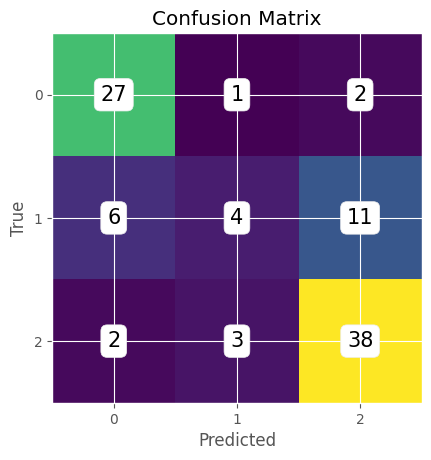

In [30]:
def plot_confusion_matrix(confusion):
    plt.figure()
    plt.imshow(confusion, cmap='viridis') 

    num_classes = confusion.shape[0]
    tick_locs = np.arange(num_classes)
    ticks = ['{}'.format(i) for i in range(num_classes)]

    plt.xticks(tick_locs, ticks)
    plt.yticks(tick_locs, ticks)

    plt.ylabel('True')
    plt.xlabel('Predicted')

    for i in range(num_classes):
        for j in range(num_classes):
            lab = f'{confusion[i, j]}'

            plt.text(j, i, lab, ha='center', va='center', color='black', fontsize=15, bbox=dict(boxstyle='round', fc='w'))

    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(confusion)


In [31]:
lab_to_int # SI have the most problematic prediction

{'non-event': 0, 'SI': 1, 'SSC': 2}

In [32]:
precision = precision_score(true_test, preds_test, average='weighted')
recall = recall_score(true_test, preds_test, average='weighted')
f1 = f1_score(true_test, preds_test, average='weighted')

print('Precision: {}\nRecall: {}\nF1: {}'.format(precision,recall,f1))

Precision: 0.69874545562906
Recall: 0.7340425531914894
F1: 0.6966184874272477


In [33]:
print('\t\tNon-Event (0)  SI (1)  SSC (2)\nPrecision:\t{}\nRecall:\t\t{}\nF1:\t\t{}'.format(
                                                                                    precision_score(true_test, preds_test, average=None),
                                                                                    recall_score(true_test, preds_test, average=None),
                                                                                    f1_score(true_test, preds_test, average=None)))

		Non-Event (0)  SI (1)  SSC (2)
Precision:	[0.77142857 0.5        0.74509804]
Recall:		[0.9        0.19047619 0.88372093]
F1:		[0.83076923 0.27586207 0.80851064]


In [34]:
acc_log_reg_full = accuracy_score(true_test, preds_test)

In [35]:
precision_log_reg_full, recall_log_reg_full, f1_score_log_reg_full, support_log_reg_full = precision_recall_fscore_support(true_test, preds_test)
precision_log_reg_full, recall_log_reg_full, f1_score_log_reg_full, support_log_reg_full 

(array([0.77142857, 0.5       , 0.74509804]),
 array([0.9       , 0.19047619, 0.88372093]),
 array([0.83076923, 0.27586207, 0.80851064]),
 array([30, 21, 43]))

#### Support Vector Classifier with Grid Search and 10-folds cross validation

In [36]:
# SVC parameters
param_grid = { 
        'C': [ 0.1,  1. , 2., 10. ], # regularization
        'class_weight':[{0:1, 1:2.2, 2:1},
                        {0:1, # class : weight
                         1:2, # give weight 2 to class 1 (SI event), and weight 1 to the other two, since SI are the most misclassified
                         2:1},  
                        {0:1, 1:1.5, 2:1.2},
                        {0:1, 1:2, 2:1.5}
                        ],
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'] # kernel coefficent for poly, rbf, sigmoid
        }


# 10 folds CV
n_splits, n_repeats = 10, 5
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2)
grid_search = GridSearchCV(estimator=SVC(), 
                            param_grid=param_grid, 
                            scoring='accuracy', 
                            refit='accuracy', 
                            n_jobs=-1, 
                            cv=cv)
gridCV = grid_search.fit(Sx_train, y_train_resampled)
gridCV.best_params_

{'C': 10.0,
 'class_weight': {0: 1, 1: 2, 2: 1.5},
 'gamma': 'auto',
 'kernel': 'rbf'}

In [37]:
svc = SVC(**gridCV.best_params_, probability=True).fit(Sx_train, y_train_resampled)

In [38]:
svm_preds = svc.predict(Sx_test)
confusion = confusion_matrix(y_test, svm_preds)
confusion

array([[28,  1,  1],
       [ 4, 12,  5],
       [ 3,  5, 35]])

In [39]:
# probabilities class assignment
svc_probs = svc.predict_proba(Sx_test)
svc_probs

array([[0.01483452, 0.28466163, 0.70050385],
       [0.01026546, 0.10715711, 0.88257743],
       [0.01628499, 0.3544277 , 0.62928732],
       [0.0068979 , 0.21285241, 0.78024969],
       [0.67750546, 0.207375  , 0.11511954],
       [0.91832022, 0.02254938, 0.05913041],
       [0.19714194, 0.36738612, 0.43547194],
       [0.01617583, 0.13543925, 0.84838493],
       [0.98232356, 0.0108853 , 0.00679114],
       [0.00596793, 0.07461106, 0.91942102],
       [0.05529643, 0.29884572, 0.64585786],
       [0.00455595, 0.07874224, 0.91670182],
       [0.01127995, 0.1359554 , 0.85276465],
       [0.03463982, 0.49483422, 0.47052596],
       [0.92741202, 0.03845333, 0.03413465],
       [0.1008662 , 0.57971369, 0.31942011],
       [0.01068118, 0.15281956, 0.83649926],
       [0.98305848, 0.01087909, 0.00606242],
       [0.71147252, 0.0483374 , 0.24019009],
       [0.0530133 , 0.48632577, 0.46066092],
       [0.00745143, 0.12516929, 0.86737928],
       [0.6561746 , 0.27066083, 0.07316457],
       [0.

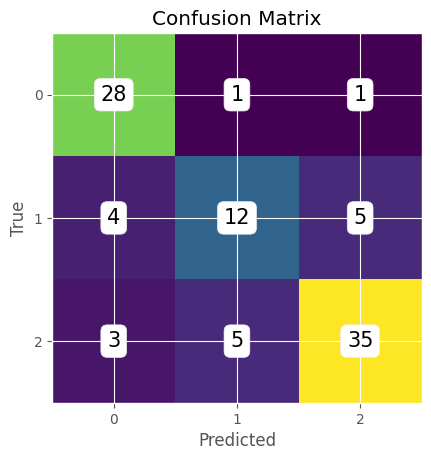

In [40]:
plot_confusion_matrix(confusion)

In [41]:
print('Accuracy on Test Set: {}'.format(accuracy_score(y_test, svm_preds)))

Accuracy on Test Set: 0.7978723404255319


In [42]:
precision = precision_score(y_test, svm_preds, average='weighted')
recall = recall_score(y_test, svm_preds, average='weighted')
f1 = f1_score(y_test, svm_preds, average='weighted')

print('Precision: {}\nRecall: {}\nF1: {}'.format(precision,recall,f1))

Precision: 0.7947586922677737
Recall: 0.7978723404255319
F1: 0.7936442989634478


In [43]:
print('\t\tNon-Event (0)  SI (1)  SSC (2)\nPrecision:\t{}\nRecall:\t\t{}\nF1:\t\t{}'.format(
                                                                                    precision_score(y_test, svm_preds, average=None),
                                                                                    recall_score(y_test, svm_preds, average=None),
                                                                                    f1_score(y_test, svm_preds, average=None)))

		Non-Event (0)  SI (1)  SSC (2)
Precision:	[0.8        0.66666667 0.85365854]
Recall:		[0.93333333 0.57142857 0.81395349]
F1:		[0.86153846 0.61538462 0.83333333]


In [44]:
print(classification_report(y_test, svm_preds))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86        30
           1       0.67      0.57      0.62        21
           2       0.85      0.81      0.83        43

    accuracy                           0.80        94
   macro avg       0.77      0.77      0.77        94
weighted avg       0.79      0.80      0.79        94



In [45]:
acc_svc_full = accuracy_score(y_test, svm_preds)
precision_svc_full, recall_svc_full, f1_score_svc_full, support_svc_full = precision_recall_fscore_support(y_test, svm_preds)
precision_svc_full, recall_svc_full, f1_score_svc_full, support_svc_full

(array([0.8       , 0.66666667, 0.85365854]),
 array([0.93333333, 0.57142857, 0.81395349]),
 array([0.86153846, 0.61538462, 0.83333333]),
 array([30, 21, 43]))

#### Random Forest with Grid Search opt and 10 folds CV

In [46]:
rf_classifier = RandomForestClassifier(random_state=2)

param_grid = {
    'n_estimators': [50, 100, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 10 folds CV
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2)

# grid search with 10-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           cv=cv)
grid_search_rf.fit(Sx_train.numpy(), y_train_resampled.numpy()) # must be numpy array

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             estimator=RandomForestClassifier(random_state=2), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [47]:
grid_search_rf.best_params_

{'bootstrap': False,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 150}

In [48]:
# best accuracy score
grid_search_rf.best_score_

0.78

In [49]:
rf = RandomForestClassifier(**grid_search_rf.best_params_, random_state=2).fit(Sx_train.numpy(), y_train_resampled.numpy())

In [50]:
y_pred_rf = rf.predict(Sx_test.numpy())
acc_rf_full = accuracy_score(y_test.numpy(), y_pred_rf)
print('Test Accuracy: ', acc_rf_full)

Test Accuracy:  0.7659574468085106


In [51]:
# get probabilities
probs_random_forest = rf.predict_proba(Sx_test.numpy())

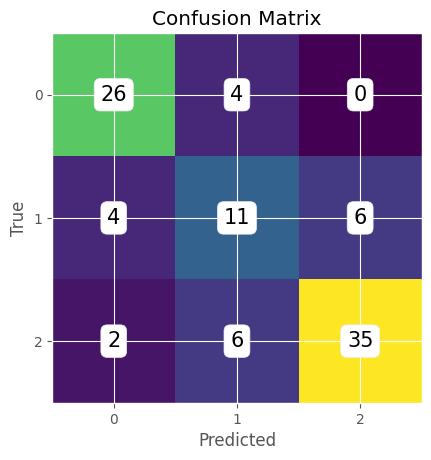

In [52]:
confusion_rf = confusion_matrix(y_test.numpy(), y_pred_rf)
plot_confusion_matrix(confusion_rf)

In [53]:
print(classification_report(y_test.numpy(), y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        30
           1       0.52      0.52      0.52        21
           2       0.85      0.81      0.83        43

    accuracy                           0.77        94
   macro avg       0.73      0.73      0.73        94
weighted avg       0.77      0.77      0.77        94



In [54]:
precision_rf_full, recall_rf_full, f1_score_rf_full, support_rf_full = precision_recall_fscore_support(y_test.numpy(), y_pred_rf)
precision_rf_full, recall_rf_full, f1_score_rf_full, support_rf_full 

(array([0.8125    , 0.52380952, 0.85365854]),
 array([0.86666667, 0.52380952, 0.81395349]),
 array([0.83870968, 0.52380952, 0.83333333]),
 array([30, 21, 43]))

In [55]:
precision_rf = precision_score(y_test.numpy(), y_pred_rf, average='weighted')
recall_rf = recall_score(y_test.numpy(), y_pred_rf, average='weighted')
f1_rf = f1_score(y_test.numpy(), y_pred_rf, average='weighted')

print('Precision: {}\nRecall: {}\nF1: {}'.format(precision_rf, recall_rf, f1_rf))

Precision: 0.7668331603528801
Recall: 0.7659574468085106
F1: 0.7659002516586594


_______

### Features Selection: 
### Classification selecting only most important features via Random Forest Gini-Importance

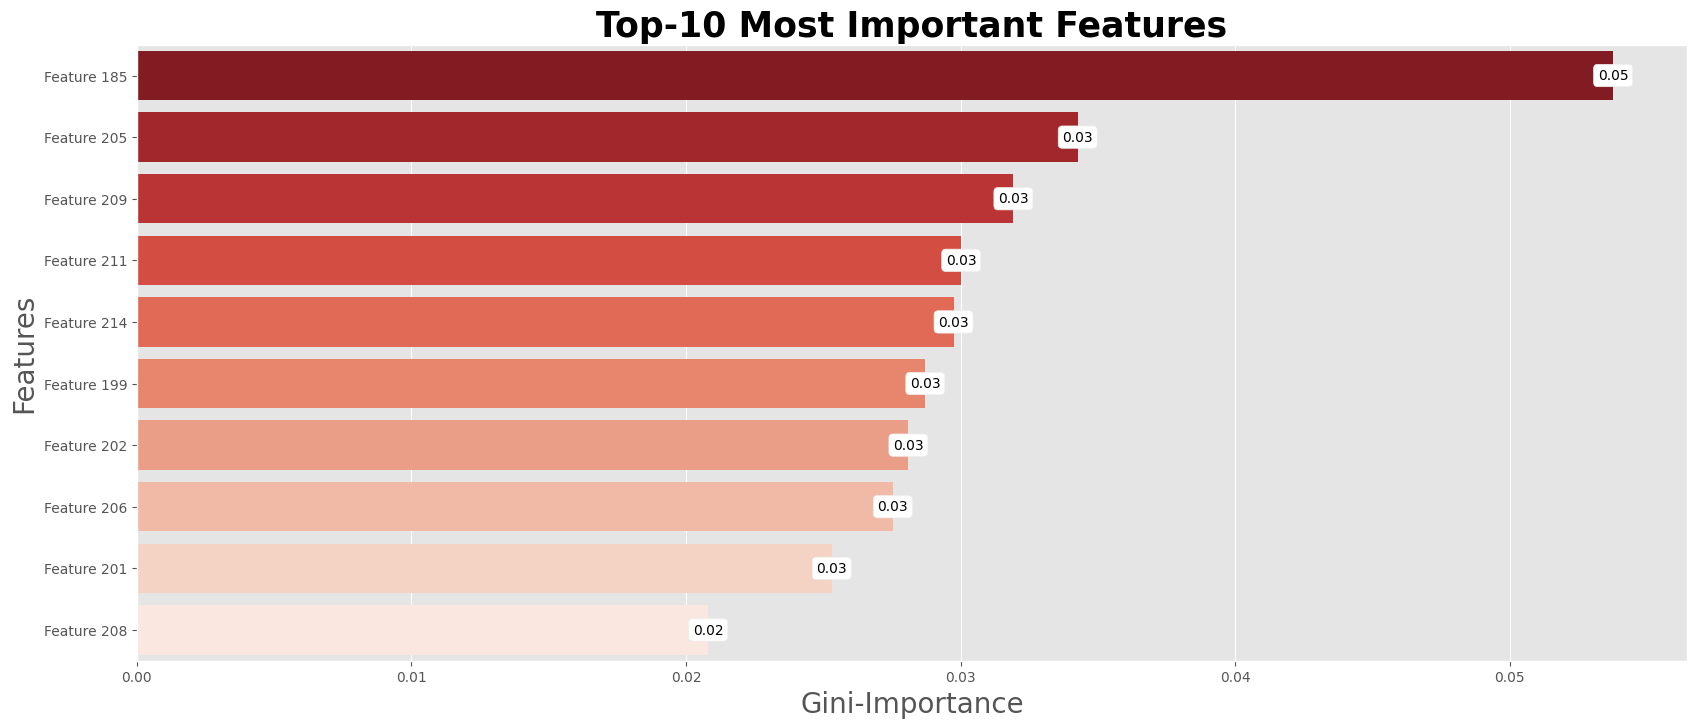

In [56]:
Sc_all_df = pd.DataFrame(Sx_train)

rf = RandomForestClassifier(max_depth=3, random_state=2)
rf.fit(Sc_all_df, y_train_resampled)

# check which features are the most important in the random forest model
feats = {}
for feature, importance in zip(Sc_all_df.columns, rf.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})


# Plot most important features
top_10 = importances[:10]
top_10['Features'] = top_10.Features.astype('str')
top_10['Features'] = ['Feature '+f for f in top_10.Features]

plt.figure(figsize=(20,8))
sns.barplot(x=top_10['Gini-Importance'], y=top_10['Features'], data=top_10,  palette='Reds_r')
plt.xlabel('Gini-Importance', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title('Top-10 Most Important Features', fontsize=25, weight = 'bold')

i=1
for p in top_10['Gini-Importance']:
    xx = p
    yy = i-1
    lab = round(p, 2)
    plt.annotate(lab, (xx, yy), 
                bbox=dict(boxstyle='round', fc='w'), 
                va='center', ha='center')
    i+=1

plt.show()

In [57]:
importances['Cumulative-Importance'] = importances['Gini-Importance'].cumsum()
importances

,Features,Gini-Importance,Cumulative-Importance
0,185,0.053770,0.053770
1,205,0.034269,0.088039
2,209,0.031926,0.119964
3,211,0.030025,0.149989
4,214,0.029746,0.179735
...,...,...,...
230,178,0.000000,1.000000
231,103,0.000000,1.000000
232,104,0.000000,1.000000
233,105,0.000000,1.000000


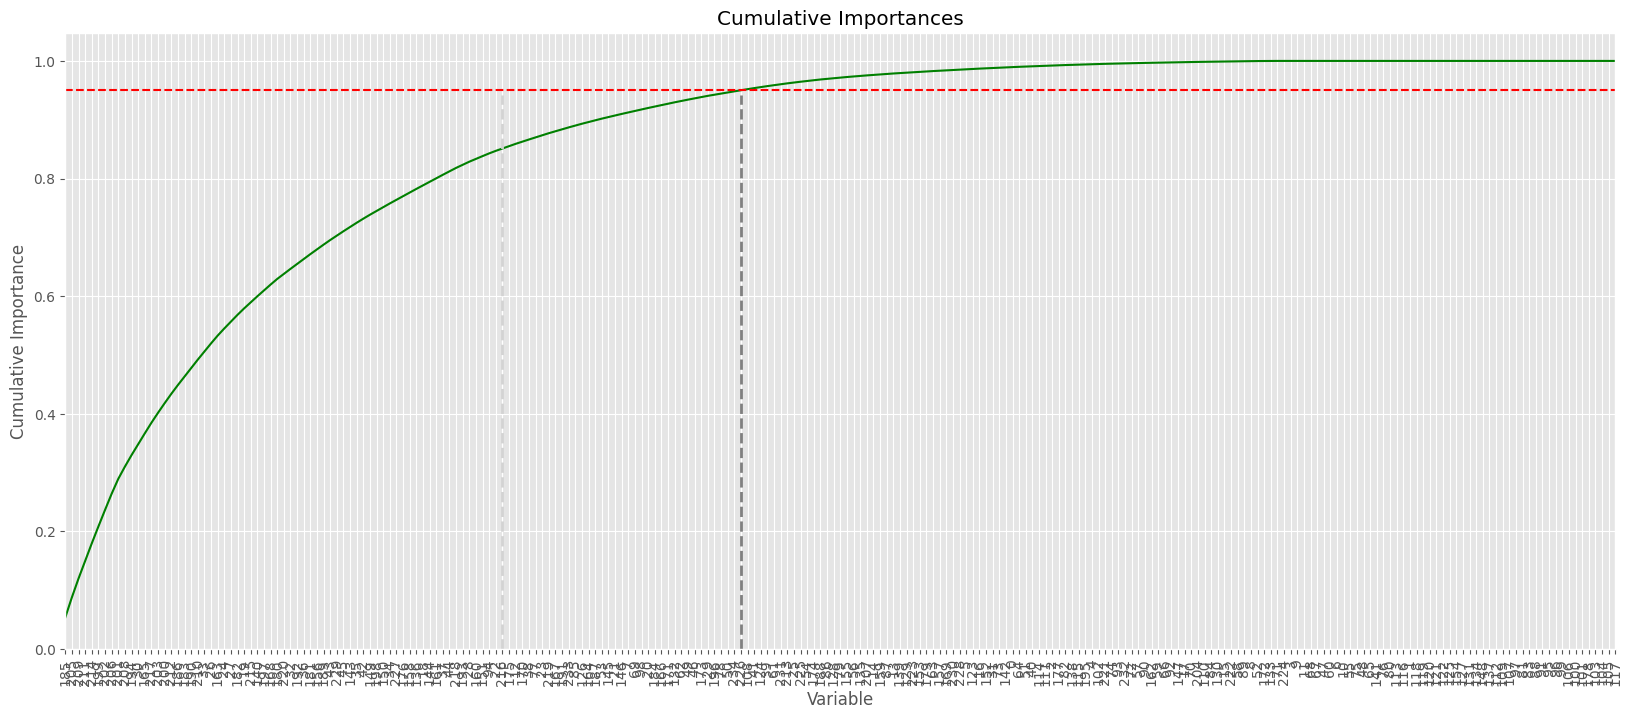

In [58]:
# cumulative importance
cumulative_importances = np.cumsum(importances['Gini-Importance'])

plt.figure(figsize=(20,8))

plt.plot(Sc_all_df.columns, cumulative_importances, 'g-')

# draw line at 95% of importance:
plt.hlines(y = 0.95, xmin=0, xmax=len(importances['Features']), color='r', linestyles='dashed')

# top 10 feats

plt.axvline(x=np.argmax(cumulative_importances >= 0.85), # 85% Gini-Importance reached
            ymin=0, ymax=.9, color='lightgray', linestyle='dashed', linewidth=2)
plt.axvline(x=np.argmax(cumulative_importances >= 0.95), # 95% Gini-Importance reached
            ymin=0, ymax=.9, color='gray', linestyle='dashed', linewidth=2)


plt.xticks(Sc_all_df.columns, importances['Features'], rotation = 'vertical')
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importances')

plt.xlim(xmin=0, xmax=len(importances['Features']) - 1)
plt.ylim(ymin=0)

plt.show()

In [59]:
# find the index where cumulative importance first reaches or exceeds 0.95 (in RF)
print('Keep', importances[importances['Cumulative-Importance'] >= 0.95].index[0] + 1, 'out of', len(importances), 'features')

Keep 103 out of 235 features


In [60]:
# index where cumulative importance first reaches or exceeds 0.95 
index_to_cut = importances[importances['Cumulative-Importance'] >= 0.95].index[0]

cut_importances = importances.iloc[:index_to_cut + 1]

col_impo_feats = cut_importances.Features.to_list()
reduced_Sc_all = Sx_train[:, col_impo_feats]
reduced_Sc_all # train set with only most importance features according to Gini-Importance

tensor([[-0.9227, -0.7743, -0.5649,  ..., -0.7115, -0.8068, -0.8450],
        [-0.4017, -0.1934, -0.0700,  ..., -1.2355, -0.7032, -0.7216],
        [-0.8186, -1.2688, -0.5250,  ..., -0.9922, -0.7690, -0.4009],
        ...,
        [-0.0415, -0.3957, -0.0281,  ..., -0.9423, -0.7903, -0.2939],
        [ 0.3188,  0.3925, -0.0927,  ...,  0.2337, -0.7286,  0.8360],
        [ 0.1274, -0.4179, -0.5727,  ..., -0.8119, -0.5549, -0.2916]])

In [61]:
np.shape(reduced_Sc_all)

torch.Size([250, 103])

In [62]:
len(y_train_resampled)

250

#### Visualization

In [63]:
# TOP 3 VISUALIZATION
top_3_feats = col_impo_feats[:3]
feats_df = pd.DataFrame(Sx_train[:, top_3_feats], columns=[str(feat) for feat in top_3_feats])
feats_df['label'] = y_train_resampled
feats_df

,185,205,209,label
0,-0.922690,-0.774283,-0.564930,0
1,-0.401660,-0.193388,-0.069992,2
2,-0.818633,-1.268765,-0.525001,0
3,-0.551544,0.181380,0.009428,1
4,-1.093547,-1.297183,-0.974520,0
...,...,...,...,...
245,0.563364,0.515303,0.377012,1
246,-1.244037,-1.549371,-1.479512,0
247,-0.041489,-0.395703,-0.028078,2
248,0.318790,0.392545,-0.092676,1


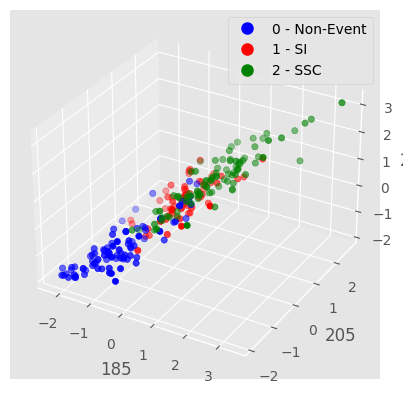

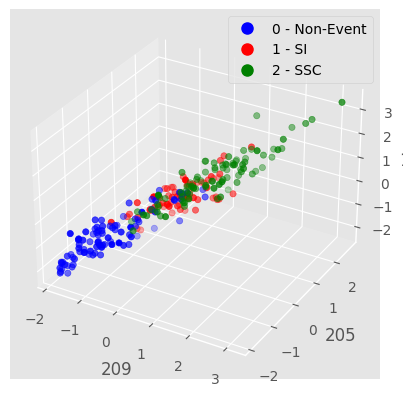

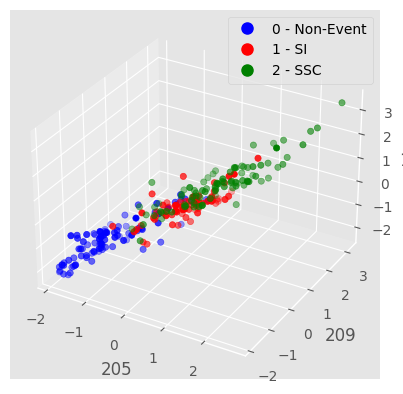

In [64]:
def plot_3D_feats(feat_discriminante, feat_y, feat_z, label):
    # 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    colors = {2: 'green', 1: 'red', 0: 'blue'}

    for label_name, label_color in colors.items():
        subset = feats_df[feats_df[label] == label_name]
        ax.scatter(subset[feat_discriminante], subset[feat_y], subset[feat_z], c=label_color, label=label_name)

    ax.set_xlabel(feat_discriminante)
    ax.set_ylabel(feat_y)
    ax.set_zlabel(feat_z)

    # legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='blue', label='0 - Non-Event', markersize=8, linestyle='None'),
        plt.Line2D([0], [0], marker='o', color='red', label='1 - SI', markersize=8, linestyle='None'),
        plt.Line2D([0], [0], marker='o', color='green', label='2 - SSC', markersize=8, linestyle='None')
    ]

    ax.legend(handles=legend_elements)

    plt.show()

plot_3D_feats(feat_discriminante = feats_df.columns[0], 
            feat_y = feats_df.columns[1],
            feat_z = feats_df.columns[2],
            label = 'label')

plot_3D_feats(feat_discriminante = feats_df.columns[2],
            feat_y = feats_df.columns[1],
            feat_z = feats_df.columns[0],
            label = 'label')
plot_3D_feats(feat_discriminante = feats_df.columns[1],
            feat_y = feats_df.columns[2],
            feat_z = feats_df.columns[0],
            label = 'label')

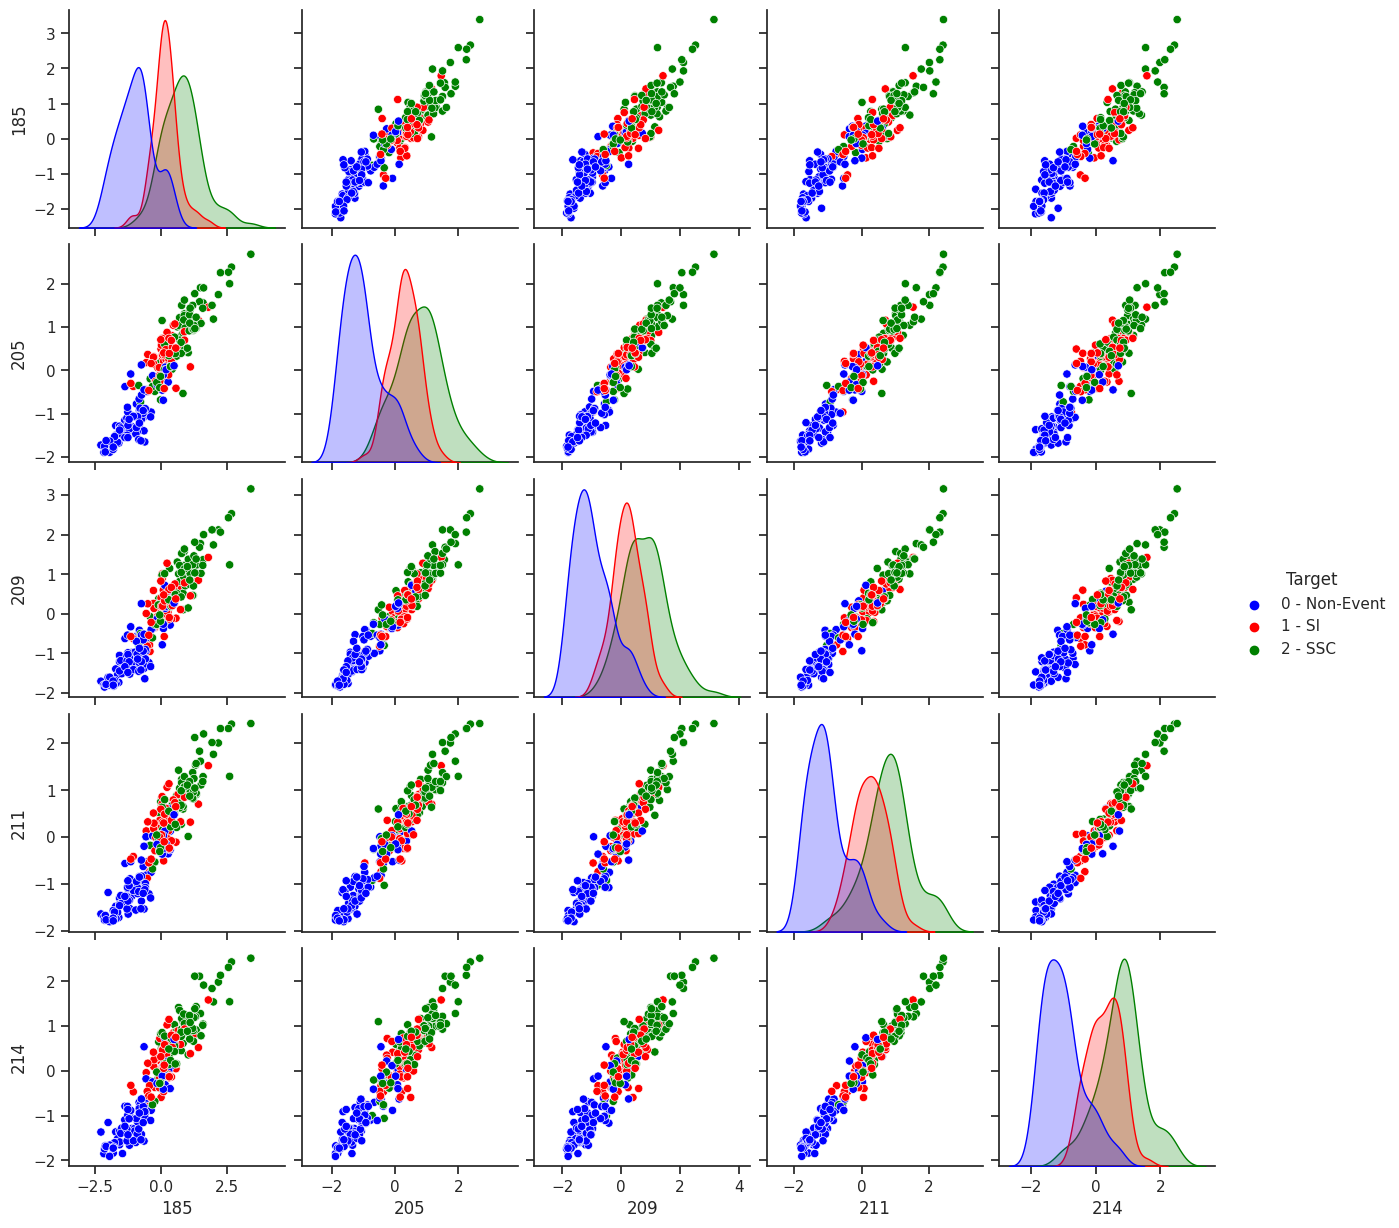

In [65]:
feature_importances = rf.feature_importances_

# select most important features
num_feats_to_select = 5
top_feats_index = np.argsort(feature_importances)[::-1][:num_feats_to_select]
top_feats_names = top_feats_index # columns names are num from 0

# df with feats and target
data_to_plot = Sc_all_df.loc[:, top_feats_index]
data_to_plot['Target'] = y_train_resampled
data_to_plot['Target'] = data_to_plot['Target'].replace({0: '0 - Non-Event', 1: '1 - SI', 2:'2 - SSC'})

# pairwise plot
sns.set(style='ticks', font_scale=1)
pairplot = sns.pairplot(data_to_plot, hue='Target', diag_kind='kde', # palette={0: 'blue', 1: 'red', 2: 'green'})
                        palette={'0 - Non-Event':'blue', 
                                 '1 - SI':'red', 
                                 '2 - SSC':'green'},
                        hue_order = ['0 - Non-Event', '1 - SI', '2 - SSC'])

# add legend
# handles = pairplot._legend_data.values()
# labels = ['0 - Non-Event', '1 - SI', '2 - SSC'] # pairplot._legend_data.keys()
# pairplot.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=3, prop={'size': 15})
# pairplot.fig.subplots_adjust(top=0.95, bottom=0.0)

plt.show()


In [66]:
plt.style.use('ggplot')

Explained variation per principal component: [0.86155915 0.04608531 0.01657126 0.01202973]


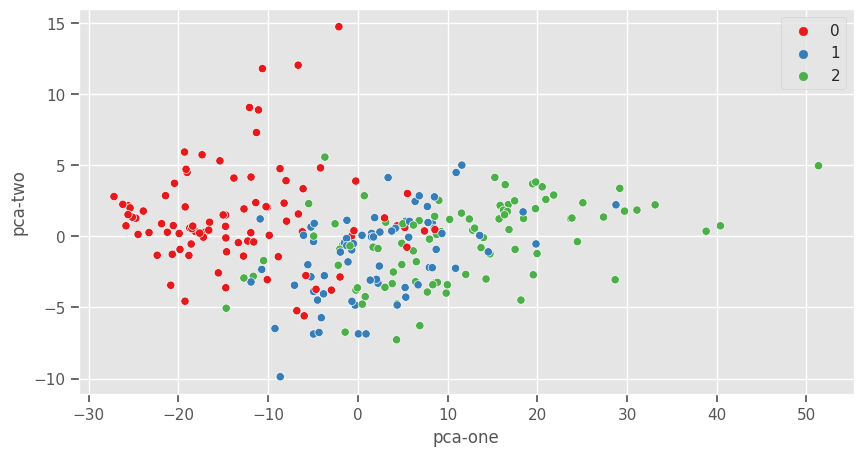

{'non-event': 0, 'SI': 1, 'SSC': 2}


In [67]:
Sc_all_df = pd.DataFrame(Sx_train)

# PCA 
num_pc = 4
pca = PCA(n_components=num_pc) 
pca_result = pca.fit_transform(Sc_all_df) 

# put PC in feats_df 
feats['pca-one'] = pca_result[:,0]
feats['pca-two'] = pca_result[:,1] 
feats['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# plot scatterplot of first PC on x axis and second PC on y axis
plt.figure(figsize=(10,5))
sns.scatterplot( 
    x='pca-one', 
    y='pca-two',
    hue=y_train_resampled, 
    palette=sns.color_palette('Set1', 3),
    data=feats,
    legend='full')
plt.show()
print(lab_to_int)

In [68]:
np.cumsum(pca.explained_variance_ratio_)

array([0.86155915, 0.90764445, 0.92421573, 0.93624544], dtype=float32)

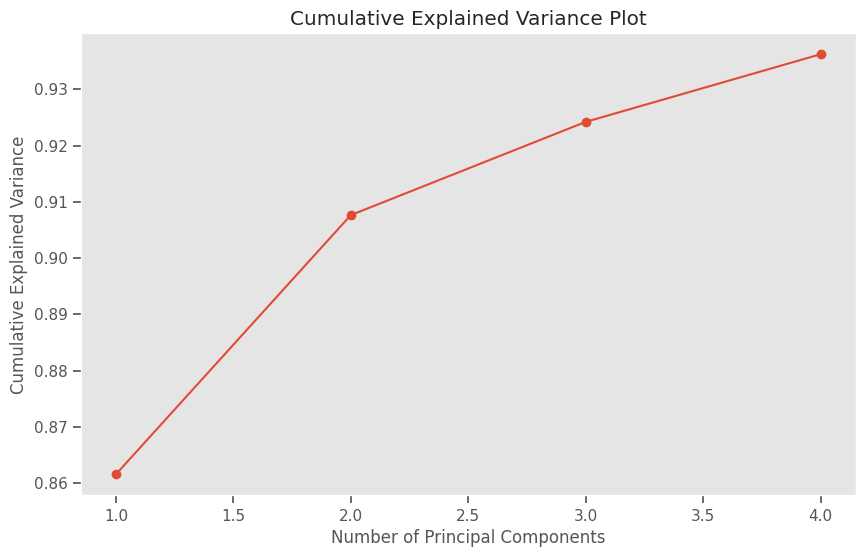

In [69]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid()
plt.show()

#### Logistic regression with 10-folds CV on REDUCED set of features

In [70]:
# Logistic regression with 10-folds CV on reduced set of features
num_folds = 10
num_epochs = 10
batch_size = 32
results_reduced = k_fold_cross_validation(reduced_Sc_all, y_train_resampled, num_folds, num_epochs, batch_size)


Fold 1/10:
Training:
Epoch 0, average loss = 0.816, accuracy = 0.622
Epoch 1, average loss = 0.705, accuracy = 0.662
Epoch 2, average loss = 0.672, accuracy = 0.662
Epoch 3, average loss = 0.660, accuracy = 0.658
Epoch 4, average loss = 0.655, accuracy = 0.653
Epoch 5, average loss = 0.650, accuracy = 0.658
Epoch 6, average loss = 0.646, accuracy = 0.662
Epoch 7, average loss = 0.641, accuracy = 0.667
Epoch 8, average loss = 0.636, accuracy = 0.671
Epoch 9, average loss = 0.632, accuracy = 0.684

Validation:
Validation, average loss = 0.706, accuracy = 0.600

Fold 2/10:
Training:
Epoch 0, average loss = 0.826, accuracy = 0.596
Epoch 1, average loss = 0.709, accuracy = 0.640
Epoch 2, average loss = 0.671, accuracy = 0.644
Epoch 3, average loss = 0.657, accuracy = 0.644
Epoch 4, average loss = 0.650, accuracy = 0.649
Epoch 5, average loss = 0.645, accuracy = 0.649
Epoch 6, average loss = 0.640, accuracy = 0.653
Epoch 7, average loss = 0.635, accuracy = 0.662
Epoch 8, average loss = 0.62

In [71]:
acc, precision, recall, f1 = 0, 0, 0, 0

for k in results_reduced.keys():
    acc += results_reduced[k]['validation_accuracy']
    precision += results_reduced[k]['precision']
    recall += results_reduced[k]['recall']
    f1 += results_reduced[k]['F1']

print('Average accuracy (10-folds Cross-Validation): {}'.format(acc/num_folds))
print('Average precision (10-folds Cross-Validation): {}'.format(precision/num_folds))
print('Average recall (10-folds Cross-Validation): {}'.format(recall/num_folds))
print('Average F1 (10-folds Cross-Validation): {}'.format(f1/num_folds))

Average accuracy (10-folds Cross-Validation): 0.6640000194311142
Average precision (10-folds Cross-Validation): 0.683649927849928
Average recall (10-folds Cross-Validation): 0.6639999999999999
Average F1 (10-folds Cross-Validation): 0.6273821632369214


In [72]:
max_recall = 0
for k in results_reduced.keys():
    if results_reduced[k]['recall'] > max_recall:
        max_recall = results_reduced[k]['recall']
        new_best_model = k

# model with highest recall
print('model with highest recall: fold {}, recall {}'.format(new_best_model, 
                                                             results_reduced[new_best_model]['recall'] ))

model with highest recall: fold 2, recall 0.72


In [73]:
best_model = results_reduced[new_best_model]['model']
criterion = torch.nn.NLLLoss() # negative log likelihood loss

# TEST SET
# accuracy
reduced_test = Sx_test[:, col_impo_feats]

resp = best_model.forward(reduced_test)
avg_loss = criterion(resp, y_test)

y_hat = resp.argmax(dim=1)
acc = (y_test == y_hat).float().mean()

print('Model accuracy: ', acc.item())

# confusion matrix
preds_test = y_hat.numpy()
true_test = y_test.numpy()
confusion = confusion_matrix(true_test, preds_test)

# probabilities of class assignment
best_model.eval() 
with torch.no_grad():
    logits = best_model(reduced_test)
    probs = torch.softmax(logits, dim=1)

Model accuracy:  0.7553191781044006


In [74]:
acc_log_reg_reduced = accuracy_score(true_test, preds_test)

In [75]:
precision_log_reg_reduced, recall_log_reg_reduced, f1_score_log_reg_reduced, support_log_reg_reduced = precision_recall_fscore_support(true_test, preds_test)
precision_log_reg_reduced, recall_log_reg_reduced, f1_score_log_reg_reduced, support_log_reg_reduced

(array([0.79411765, 0.75      , 0.73214286]),
 array([0.9       , 0.14285714, 0.95348837]),
 array([0.84375   , 0.24      , 0.82828283]),
 array([30, 21, 43]))

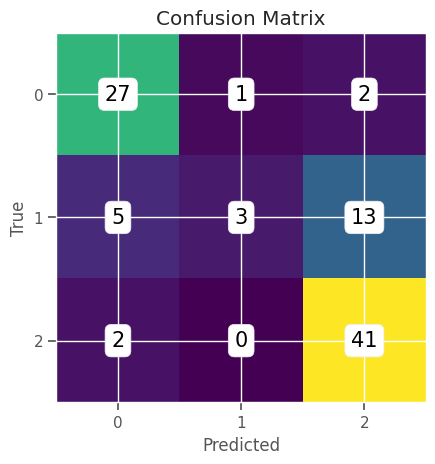

In [76]:
plot_confusion_matrix(confusion)

#### SVC with Grid Search and 10 folds CV on REDUCED feature matrix

In [77]:
# SVC parameters
param_grid = { 
        'C': [ 0.1,  1. , 2., 10. ], # regularization
        'class_weight':[{0:1, 1:2.2, 2:1},
                        {0:1, # class : weight
                         1:2, # give weight 2 to class 1 (SI event), and weight 1 to the other two, since SI are the most misclassified
                         2:1},  
                        {0:1, 1:1.5, 2:1.2},
                        {0:1, 1:2, 2:1.5}
                        ],
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'] # kernel coefficent for poly, rbf, sigmoid
        }


# 10 folds CV
n_splits, n_repeats = 10, 5
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2)
grid_search = GridSearchCV(estimator=SVC(), 
                            param_grid=param_grid, 
                            scoring='accuracy', 
                            refit='accuracy', 
                            n_jobs=-1, 
                            cv=cv)
gridCV = grid_search.fit(reduced_Sc_all, y_train_resampled)
gridCV.best_params_

{'C': 10.0,
 'class_weight': {0: 1, 1: 1.5, 2: 1.2},
 'gamma': 'scale',
 'kernel': 'rbf'}

In [78]:
svc_reduced = SVC(**gridCV.best_params_, probability=True).fit(reduced_Sc_all, y_train_resampled)

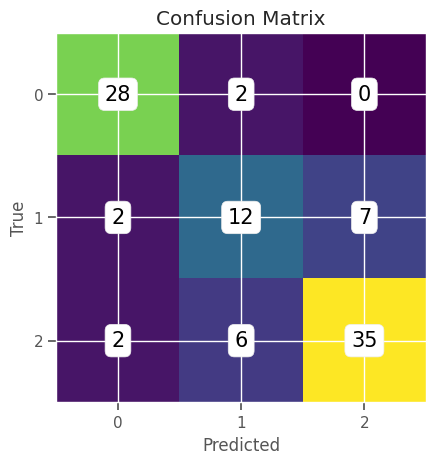

In [79]:
svm_preds = svc_reduced.predict(reduced_test)
confusion = confusion_matrix(y_test, svm_preds)
plot_confusion_matrix(confusion)

In [80]:
precision_svc_reduced, recall_svc_reduced, f1_score_svc_reduced, support_svc_reduced = precision_recall_fscore_support(y_test, svm_preds)
precision_svc_reduced, recall_svc_reduced, f1_score_svc_reduced, support_svc_reduced 

(array([0.875     , 0.6       , 0.83333333]),
 array([0.93333333, 0.57142857, 0.81395349]),
 array([0.90322581, 0.58536585, 0.82352941]),
 array([30, 21, 43]))

In [81]:
acc_svc_reduced = accuracy_score(y_test, svm_preds)

In [82]:
print('Accuracy on Test Set: {}'.format(accuracy_score(y_test, svm_preds)))

precision = precision_score(y_test, svm_preds, average='weighted')
recall = recall_score(y_test, svm_preds, average='weighted')
f1 = f1_score(y_test, svm_preds, average='weighted')

print('Precision: {}\nRecall: {}\nF1: {}'.format(precision,recall,f1))

Accuracy on Test Set: 0.7978723404255319
Precision: 0.7945035460992909
Recall: 0.7978723404255319
F1: 0.795757679002766


In [83]:
print(classification_report(y_test, svm_preds))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        30
           1       0.60      0.57      0.59        21
           2       0.83      0.81      0.82        43

    accuracy                           0.80        94
   macro avg       0.77      0.77      0.77        94
weighted avg       0.79      0.80      0.80        94



#### Random Forest on REDUCED feature matrix

In [84]:
rrf_classifier = RandomForestClassifier(random_state=2)

param_grid = {
    'n_estimators': [50, 100, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 10 folds CV
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2)

# grid search with 10-fold cross-validation
grid_search_rrf = GridSearchCV(estimator=rrf_classifier, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           cv=cv)
grid_search_rrf.fit(reduced_Sc_all.numpy(), y_train_resampled.numpy()) # must be numpy array


# train
rrf = RandomForestClassifier(**grid_search_rrf.best_params_, random_state=2).fit(reduced_Sc_all.numpy(), y_train_resampled.numpy())
# prediced
y_pred_rf = rrf.predict(reduced_test.numpy())


In [85]:
grid_search_rrf.best_params_

{'bootstrap': False,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

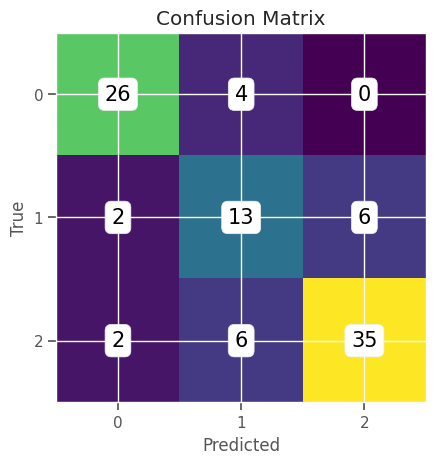

In [86]:
confusion_rrf = confusion_matrix(y_test.numpy(), y_pred_rf)
plot_confusion_matrix(confusion_rrf)

In [87]:
print('Test Accuracy:')
accuracy_score(y_test.numpy(), y_pred_rf)
print(classification_report(y_test.numpy(), y_pred_rf))

Test Accuracy:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        30
           1       0.57      0.62      0.59        21
           2       0.85      0.81      0.83        43

    accuracy                           0.79        94
   macro avg       0.76      0.77      0.76        94
weighted avg       0.79      0.79      0.79        94



In [88]:
acc_rf_reduced = accuracy_score(y_test.numpy(), y_pred_rf)

In [89]:
precision_rrf_reduced, recall_rrf_reduced, f1_score_rrf_reduced, support_rrf_reduced = precision_recall_fscore_support(y_test.numpy(), y_pred_rf)
precision_rrf_reduced, recall_rrf_reduced, f1_score_rrf_reduced, support_rrf_reduced 

(array([0.86666667, 0.56521739, 0.85365854]),
 array([0.86666667, 0.61904762, 0.81395349]),
 array([0.86666667, 0.59090909, 0.83333333]),
 array([30, 21, 43]))

Precision --> TP/(TP+FP) --> correctly prediced positives, FP are mostly avoided  
Recall --> TP/(TP+FN) --> lower recall means higher number of FN

_______

### Summarize performances

In [90]:
result_report = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Logistic Regression (Full)': [precision_log_reg_full.mean(), recall_log_reg_full.mean(), f1_score_log_reg_full.mean(), acc_log_reg_full],
    'SVC (Full)': [precision_svc_full.mean(), recall_svc_full.mean(), f1_score_svc_full.mean(), acc_svc_full],
    'Random Forest (Full)': [precision_rf_full.mean(), recall_rf_full.mean(), f1_score_rf_full.mean(), acc_rf_full],
    'Logistic Regression (Reduced)': [precision_log_reg_reduced.mean(), recall_log_reg_reduced.mean(), f1_score_log_reg_reduced.mean(), acc_log_reg_reduced],
    'SVC (Reduced)': [precision_svc_reduced.mean(), recall_svc_reduced.mean(), f1_score_svc_reduced.mean(), acc_svc_reduced],
    'Random Forest (Reduced)': [precision_rrf_reduced.mean(), recall_rrf_reduced.mean(), f1_score_rrf_reduced.mean(), acc_rf_reduced]
}

result_report_df = pd.DataFrame(result_report)

result_report_df

,Metric,Logistic Regression (Full),SVC (Full),Random Forest (Full),Logistic Regression (Reduced),SVC (Reduced),Random Forest (Reduced)
0,Precision,0.672176,0.773442,0.729989,0.758754,0.769444,0.761848
1,Recall,0.658066,0.772905,0.734810,0.665449,0.772905,0.766556
2,F1-Score,0.638381,0.770085,0.731951,0.637344,0.770707,0.763636
3,Accuracy,0.734043,0.797872,0.765957,0.755319,0.797872,0.787234


In [91]:
colmap = sns.light_palette("green", as_cmap=True)
result_report_df.style.background_gradient(cmap = colmap)

,Metric,Logistic Regression (Full),SVC (Full),Random Forest (Full),Logistic Regression (Reduced),SVC (Reduced),Random Forest (Reduced)
0,Precision,0.672176,0.773442,0.729989,0.758754,0.769444,0.761848
1,Recall,0.658066,0.772905,0.734810,0.665449,0.772905,0.766556
2,F1-Score,0.638381,0.770085,0.731951,0.637344,0.770707,0.763636
3,Accuracy,0.734043,0.797872,0.765957,0.755319,0.797872,0.787234


In [92]:
# result_report_df.to_csv('res/3_class_result_SVMSMOTE.csv')

In [93]:
result_report_detailed = {
    'Metric Type': ['', 'Precision', '', '', 'Recall', '', '', 'F1-Score', '' ],
    'Metric': ['Non-Event (0)', 'SI (1)', 'SSC (2)', 'Non-Event (0)', 'SI (1)', 'SSC (2)', 'Non-Event (0)', 'SI (1)', 'SSC (2)'],
    'Logistic Regression (Full)': np.concatenate((precision_log_reg_full, recall_log_reg_full, f1_score_log_reg_full)),
    'SVC (Full)': np.concatenate((precision_svc_full, recall_svc_full, f1_score_svc_full)),
    'Random Forest (Full)': np.concatenate((precision_rf_full, recall_rf_full, f1_score_rf_full)),
    'Logistic Regression (Reduced)': np.concatenate((precision_log_reg_reduced, recall_log_reg_reduced, f1_score_log_reg_reduced)),
    'SVC (Reduced)': np.concatenate((precision_svc_reduced, recall_svc_reduced, f1_score_svc_reduced)),
    'Random Forest (Reduced)': np.concatenate((precision_rrf_reduced, recall_rrf_reduced, f1_score_rrf_reduced))
}

result_report_df_detailed = pd.DataFrame(result_report_detailed)

result_report_df_detailed.set_index('Metric Type')

,Metric,Logistic Regression (Full),SVC (Full),Random Forest (Full),Logistic Regression (Reduced),SVC (Reduced),Random Forest (Reduced)
Metric Type,,,,,,,
,Non-Event (0),0.771429,0.800000,0.812500,0.794118,0.875000,0.866667
Precision,SI (1),0.500000,0.666667,0.523810,0.750000,0.600000,0.565217
,SSC (2),0.745098,0.853659,0.853659,0.732143,0.833333,0.853659
,Non-Event (0),0.900000,0.933333,0.866667,0.900000,0.933333,0.866667
Recall,SI (1),0.190476,0.571429,0.523810,0.142857,0.571429,0.619048
,SSC (2),0.883721,0.813953,0.813953,0.953488,0.813953,0.813953
,Non-Event (0),0.830769,0.861538,0.838710,0.843750,0.903226,0.866667
F1-Score,SI (1),0.275862,0.615385,0.523810,0.240000,0.585366,0.590909
,SSC (2),0.808511,0.833333,0.833333,0.828283,0.823529,0.833333


In [94]:
result_report_df_detailed.style.background_gradient(cmap = colmap)

,Metric Type,Metric,Logistic Regression (Full),SVC (Full),Random Forest (Full),Logistic Regression (Reduced),SVC (Reduced),Random Forest (Reduced)
0,,Non-Event (0),0.771429,0.800000,0.812500,0.794118,0.875000,0.866667
1,Precision,SI (1),0.500000,0.666667,0.523810,0.750000,0.600000,0.565217
2,,SSC (2),0.745098,0.853659,0.853659,0.732143,0.833333,0.853659
3,,Non-Event (0),0.900000,0.933333,0.866667,0.900000,0.933333,0.866667
4,Recall,SI (1),0.190476,0.571429,0.523810,0.142857,0.571429,0.619048
5,,SSC (2),0.883721,0.813953,0.813953,0.953488,0.813953,0.813953
6,,Non-Event (0),0.830769,0.861538,0.838710,0.843750,0.903226,0.866667
7,F1-Score,SI (1),0.275862,0.615385,0.523810,0.240000,0.585366,0.590909
8,,SSC (2),0.808511,0.833333,0.833333,0.828283,0.823529,0.833333


In [95]:
# result_report_df_detailed.to_csv('res/3_class_result_per_class_SVMSMOTE.csv')